# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [116]:
## Business Understanding


**Business Objective** - Dealers want to know: “What drives used car prices, and how can we predict them to fine-tune inventory decisions?”

**Technical Objective** - Build predictive models to estimate a car’s resale price based on available features.

From a data perspective, this project is about predicting the continuous target variable **price** of used cars using regression models. We will use numeric predictors such as **car age** and **odometer** together with encoded features like **condition**, **fuel**, **drive**, and **title status**. By training and evaluating models such as multiple linear, polynomial, ridge, and lasso regression, we aim to both minimize prediction error (**RMSE, MAE**) and interpret coefficients to identify the strongest drivers of car prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [117]:
### Data Understanding


We’ll load the data and do just enough profiling to decide what features are worth using:
- Check numeric columns (price, year, odometer)
- Check candidate categoricals for **coverage** and **cardinality**
- Quick, visual relationship checks to see if a categorical looks useful

In [118]:
## Setup and Load Data

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)
#pd.set_option('display.float_format', '{:,.0f}'.format)
#pd.set_option('display.precision', 5)


In [120]:
# Loading data
df_raw = pd.read_csv("data/vehicles.csv")
print("Shape:", df_raw.shape)
df_raw.head(-10)

Shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426865,7301949193,wyoming,34590,2020.0,alfa-romeo,romeo giulia sedan 4d,good,NaN,other,2498.0,clean,other,ZARFAMAN7L7629796,rwd,NaN,sedan,black,wy
426866,7301949190,wyoming,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,clean,automatic,JN8AZ2NF5G9611039,rwd,NaN,other,black,wy
426867,7301949178,wyoming,28990,2018.0,jaguar,xe 25t prestige sedan 4d,good,NaN,other,16841.0,clean,other,SAJAE4FX8JCP34579,rwd,NaN,sedan,white,wy
426868,7301843288,wyoming,0,2010.0,toyota,venza,excellent,6 cylinders,gas,155000.0,clean,automatic,4T3BK3BB0AU043625,4wd,NaN,NaN,blue,wy


In [121]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [122]:
df_raw.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


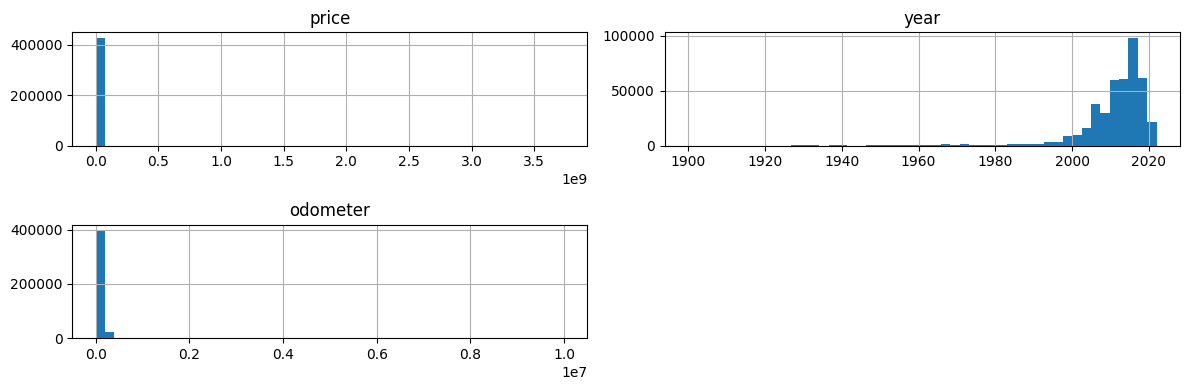

In [123]:
df_raw[['price','year','odometer']].hist(figsize=(12, 4), bins=50);
plt.tight_layout()

In [124]:
#Profile Categorical Columns
cat_candidates = ['condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color','manufacturer']
cat_profile = pd.DataFrame({
    'coverage': df_raw[cat_candidates].count() / len(df_raw),
    'num_unique': [df_raw[c].nunique() for c in cat_candidates],
    'top_category': [df_raw[c].value_counts().index[0] for c in cat_candidates]
})
display(cat_profile)

,coverage,num_unique,top_category
condition,0.592148,6,good
cylinders,0.583775,8,6 cylinders
fuel,0.992942,5,gas
title_status,0.980692,6,clean
transmission,0.994012,3,automatic
drive,0.694137,3,4wd
size,0.282325,4,full-size
type,0.782473,13,sedan
paint_color,0.694989,12,white
manufacturer,0.958663,42,ford


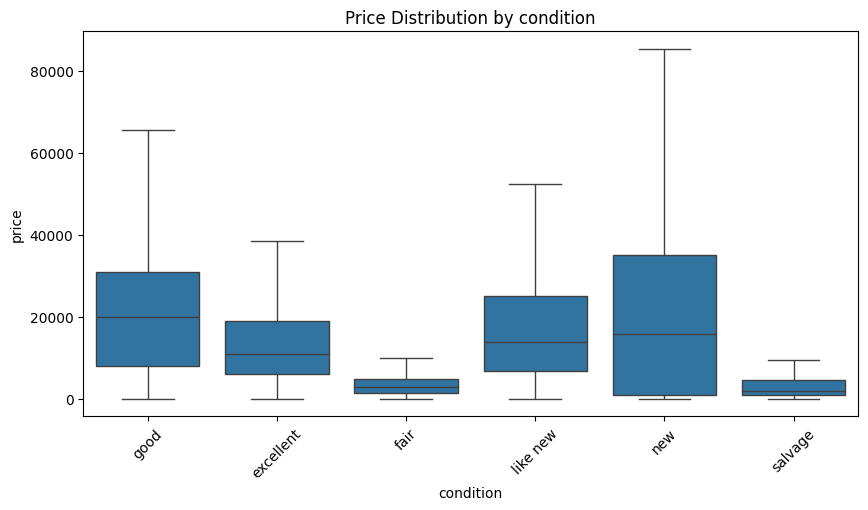

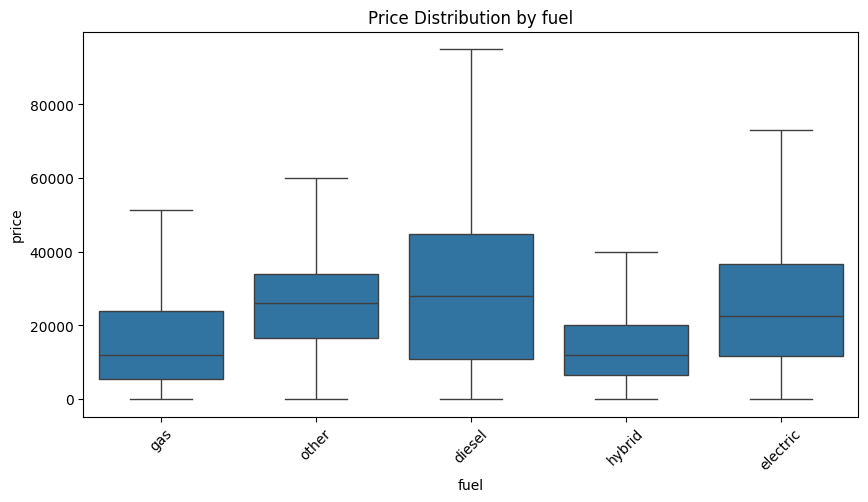

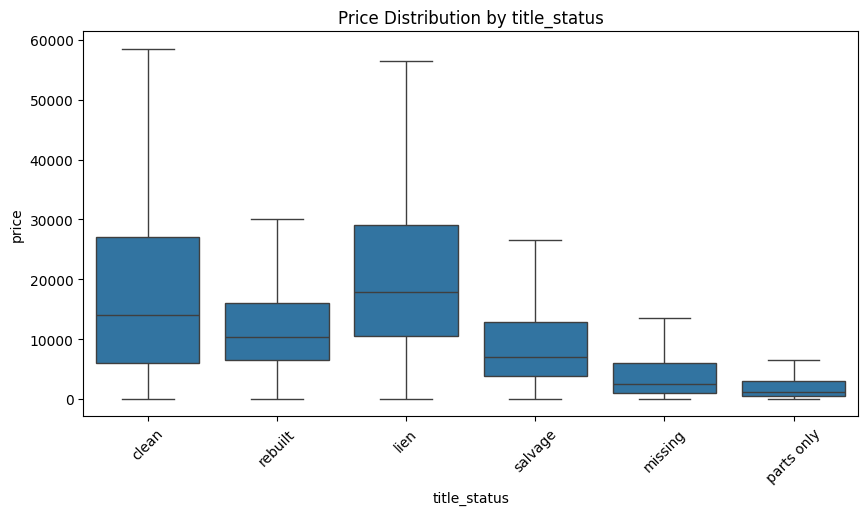

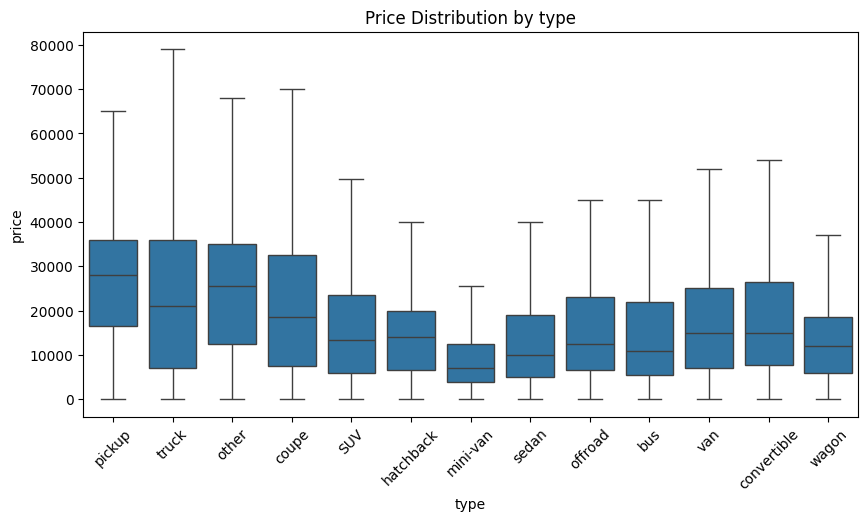

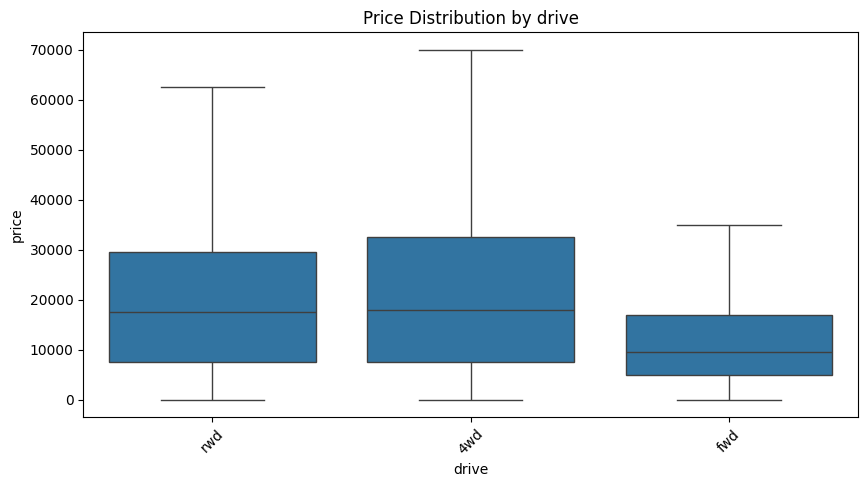

In [125]:
# We select these four features that have maximum coverage
features_to_plot = ['condition', 'fuel', 'title_status', 'type', 'drive']
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_raw, x=feature, y='price', showfliers=False)
    plt.title(f'Price Distribution by {feature}')
    plt.xticks(rotation=45)
    plt.show()

# This helps to visualize the relationship between selected features and price using boxplots.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [126]:
df_clean = df_raw.copy()

# We set realistic min/max price and odometer values to remove extreme outliers and invalid entries (like price=0).
MIN_PRICE, MAX_PRICE = 1000, 65000
MIN_ODOM, MAX_ODOM = 1000, 300000
CURRENT_YEAR = 2025

# Apply the cleaning filters.
df_clean = df_clean[df_clean.price.between(MIN_PRICE, MAX_PRICE)]
df_clean = df_clean[df_clean.odometer.between(MIN_ODOM, MAX_ODOM)]

# Feature Engineering: Create 'car_age' from the 'year' column.
df_clean['car_age'] = CURRENT_YEAR - df_clean['year']
df_clean.dropna(subset=['car_age'], inplace=True)
df_clean['car_age'] = df_clean['car_age'].astype(int)

# We choose features with good coverage, reasonable cardinality, and a clear relationship with price.
features = ['car_age', 'odometer', 'condition', 'fuel', 'type', 'title_status', 'drive']
df_model = df_clean[features + ['price']].dropna()

print('Final dataset shape:', df_model.shape)

Final dataset shape: (156357, 8)


In [127]:
# Separate the dataset into features (X) and the target variable (y).
X = df_model.drop('price', axis=1)
y = df_model['price']

# Define which columns are numeric and which are categorical.
# This is essential for the ColumnTransformer to know which preprocessing step to apply to each column.
numeric_features = ['car_age', 'odometer']
categorical_features = ['condition', 'fuel', 'type', 'title_status', 'drive']

# Create a preprocessing pipeline using ColumnTransformer.
# - Numeric features are scaled using StandardScaler to have a mean of 0 and variance of 1. This helps linear models converge faster.
# - Categorical features are converted into numerical format using OneHotEncoder. `handle_unknown='ignore'` prevents errors if new categories appear in test data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [128]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [129]:
# Create am array to store results and set up cross-validation.
results = []
# 5-fold cross-validation for robust evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42) 

**Simple Model**

In [130]:
# A simple baseline model using only the odometer to predict price.
# This gives us a benchmark to see if more complex models are actually better.
X_base = X[['odometer']]
pipe_base = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

# Evaluate the baseline model using cross-validation.
# We calculate both RMSE and MAE. Note that scikit-learn uses negative scores, so we multiply by -1.
rmse_base = -cross_val_score(pipe_base, X_base, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
mae_base = -cross_val_score(pipe_base, X_base, y, cv=cv, scoring='neg_mean_absolute_error').mean()

# Store and print the results.
results.append({'model': 'Baseline (Odometer Only)', 'RMSE': rmse_base, 'MAE': mae_base})
print(results[-1])

{'model': 'Baseline (Odometer Only)', 'RMSE': np.float64(9773.74679195584), 'MAE': np.float64(7607.731392419519)}


**Multiple Regression Model with numeric columns**

In [131]:
# Create a model with both numeric features (car_age and odometer).
X_numeric = X[numeric_features]
pipe_numeric = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

# Evaluate and store the results.
rmse_numeric = -cross_val_score(pipe_numeric, X_numeric, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
mae_numeric = -cross_val_score(pipe_numeric, X_numeric, y, cv=cv, scoring='neg_mean_absolute_error').mean()
results.append({'model': 'Linear (Numeric Only)', 'RMSE': rmse_numeric, 'MAE': mae_numeric})
print(results[-1])

{'model': 'Linear (Numeric Only)', 'RMSE': np.float64(9461.325393930088), 'MAE': np.float64(7350.389629297757)}


**Multiple Regression Model with all selected columns**

In [132]:
# Build a full linear regression model using both numeric and categorical features.
# The pipeline now includes our 'preprocessor' to handle both data types correctly.
pipe_full = Pipeline([('prep', preprocessor), ('model', LinearRegression())])

# Evaluate the full model.
rmse_full = -cross_val_score(pipe_full, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
mae_full = -cross_val_score(pipe_full, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()
results.append({'model': 'Linear (Full)', 'RMSE': rmse_full, 'MAE': mae_full})
print(results[-1])

{'model': 'Linear (Full)', 'RMSE': np.float64(7221.326406442449), 'MAE': np.float64(5301.232764668019)}


**Polynomial Regression Model**

In [133]:
# Create a preprocessor specifically for the polynomial model.
# We apply PolynomialFeatures only to the numeric columns to capture non-linear relationships (e.g., depreciation is not linear).
pre_poly = ColumnTransformer(
    transformers=[
        ('poly', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)) # Degree 2 captures interactions and squared terms
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Build the polynomial regression pipeline.
pipe_poly = Pipeline([('prep', pre_poly), ('model', LinearRegression())])
print(pipe_poly)
print('')

# Evaluate and store the results.
rmse_poly = -cross_val_score(pipe_poly, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
mae_poly = -cross_val_score(pipe_poly, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()
results.append({'model': 'Polynomial (Full)', 'RMSE': rmse_poly, 'MAE': mae_poly})
print(results[-1])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('poly',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['car_age', 'odometer']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['condition', 'fuel', 'type',
                                                   'title_status',
                                                   'drive'])])),
                ('model', LinearRegression())])

{'model': 'Polynomial (Full)', 'RMSE': np.float64(6529.639058363539), 'MAE': np.float

**Ridge Regression Model**

In [134]:
# Build a Ridge Regression pipeline.
pipe_ridge = Pipeline([('prep', preprocessor), ('model', Ridge(random_state=42))])

# Use GridSearchCV to find the best regularization strength ('alpha').
grid_ridge = GridSearchCV(pipe_ridge, {'model__alpha': [0.1, 1.0, 10.0]}, cv=cv, scoring='neg_root_mean_squared_error')
grid_ridge.fit(X, y)

# Extract the best parameters and scores.
best_alpha_ridge = grid_ridge.best_params_['model__alpha']
best_rmse_ridge = -grid_ridge.best_score_
best_mae_ridge = -cross_val_score(grid_ridge.best_estimator_, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()

# Store and print the results.
results.append({'model': f'Ridge (alpha={best_alpha_ridge})', 'RMSE': best_rmse_ridge, 'MAE': best_mae_ridge})
print(results[-1])

{'model': 'Ridge (alpha=10.0)', 'RMSE': np.float64(7221.369080623369), 'MAE': np.float64(5301.206558653141)}


**LASSO Regression**

In [135]:
# Use the more efficient LassoCV to find the best alpha.
# This is faster than GridSearchCV for Lasso because it computes the regularization path.
pipe_lasso_cv = Pipeline([
    ('prep', preprocessor),
    ('model', Lasso(alpha=0.1, max_iter=5000, tol=0.01, random_state=42))
])

# Fit the model once. It handles the cross-validation internally to find the best alpha.
pipe_lasso_cv.fit(X, y)

# Evaluate the final model with the best alpha to get RMSE and MAE scores.
best_rmse_lasso = -cross_val_score(pipe_lasso_cv, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
best_mae_lasso = -cross_val_score(pipe_lasso_cv, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()

# Store and print the results.
results.append({'model': f'LASSO (alpha={best_alpha_lasso:.4f})', 'RMSE': best_rmse_lasso, 'MAE': best_mae_lasso})
print(results[-1])

{'model': 'LASSO (alpha=7.2901)', 'RMSE': np.float64(7221.3305333976605), 'MAE': np.float64(5301.244097013778)}


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Final Model Comparison**

In [136]:
# Convert the results list into a DataFrame for easy comparison.
results_df = pd.DataFrame(results).sort_values('RMSE').set_index('model')

# Display the final results, sorted by RMSE, to identify the best-performing model.
display(results_df)

,RMSE,MAE
model,,
Polynomial (Full),6529.639058,4750.985185
Linear (Full),7221.326406,5301.232765
LASSO (alpha=7.2901),7221.330533,5301.244097
Ridge (alpha=10.0),7221.369081,5301.206559
Linear (Numeric Only),9461.325394,7350.389629
Baseline (Odometer Only),9773.746792,7607.731392


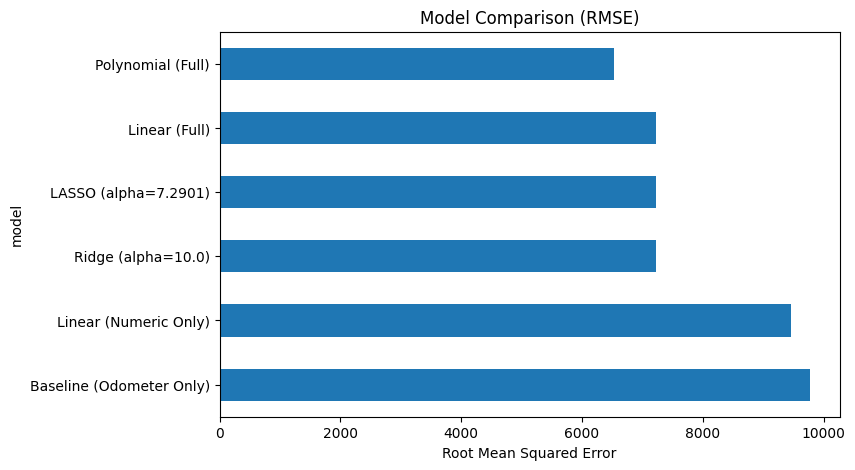

In [137]:
# Visualize the model comparison results with a bar plot.
results_df['RMSE'].plot(kind='barh', figsize=(8, 5), title='Model Comparison (RMSE)')
plt.xlabel('Root Mean Squared Error')
plt.gca().invert_yaxis()
plt.show()

**Best Model: Polynomial Regression**

Below we diagnose the champion model (Polynomial Full) with **Residual Dirstribution**

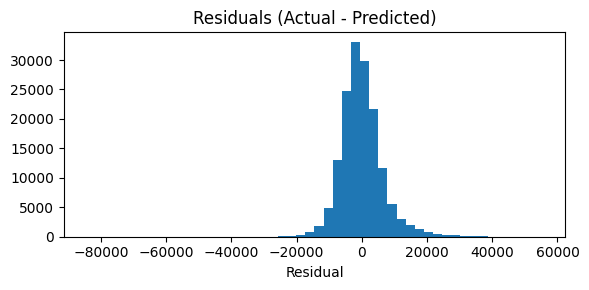

In [138]:
# Fit the best-performing model (Polynomial Regression) on the entire dataset.
pipe_poly.fit(X, y)
y_pred = pipe_poly.predict(X)

# Calculate residuals (the difference between actual and predicted prices)..
resid = y - y_pred

# A good model should have residuals that are randomly scattered around zero.
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(resid, bins=50); ax.set_title('Residuals (Actual - Predicted)')
ax.set_xlabel('Residual')
plt.tight_layout(); plt.show()

**Coeffs Evaluation**

Negative Coeffs


,feature,coef
0,poly__car_age,-7006.481346
1,poly__odometer,-5518.730561
20,cat__type_hatchback,-4721.344686
28,cat__type_wagon,-4574.065953
36,cat__drive_fwd,-3939.712474
13,cat__fuel_gas,-3389.432322
25,cat__type_sedan,-3119.873810
6,cat__condition_fair,-2845.026912
10,cat__condition_salvage,-2487.510507
31,cat__title_status_missing,-2309.489815


Positive Coeffs


,feature,coef
8,cat__condition_like new,1106.015708
2,poly__car_age^2,1151.007593
5,cat__condition_excellent,1236.837640
19,cat__type_coupe,1270.940932
23,cat__type_other,1479.172727
37,cat__drive_rwd,1596.452013
18,cat__type_convertible,1725.403680
9,cat__condition_new,2200.235981
35,cat__drive_4wd,2343.260462
22,cat__type_offroad,2856.777289


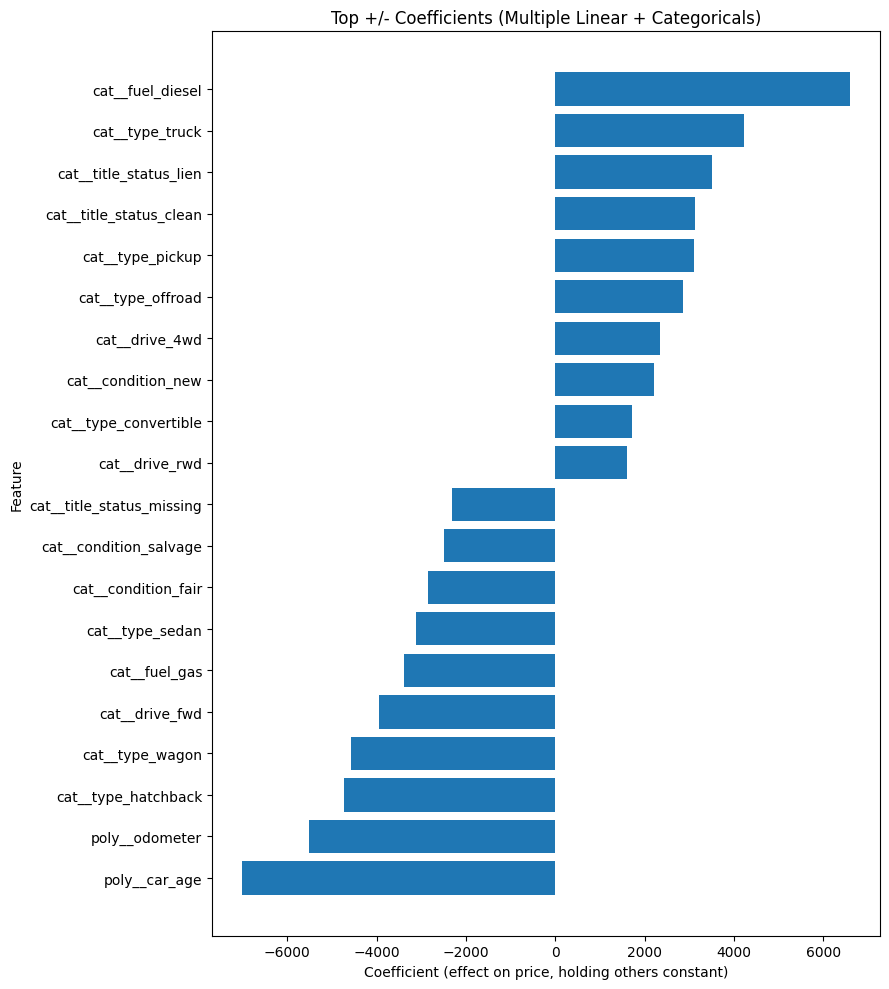

In [139]:

poly_pipe = Pipeline([('prep', pre_poly), ('model', LinearRegression())])
poly_pipe.fit(X, y)

prep_poly = poly_pipe.named_steps['prep']
feature_names = prep_poly.get_feature_names_out()  # includes polynomial-expanded numeric names + OHE cats
coefs = poly_pipe.named_steps['model'].coef_

n = min(len(feature_names), len(coefs))
coef_df = pd.DataFrame({
    'feature': feature_names[:n],
    'coef':    coefs[:n]
})

coef_df_sorted = coef_df.sort_values('coef')
print('Negative Coeffs')
display(coef_df_sorted.head(15))   # most negative (price-reducing)
print('Positive Coeffs')
display(coef_df_sorted.tail(15))   # most positive (price-increasing)

# 5) Plot top +/- coefficients (by signed magnitude)
top_k = 10
plot_df = pd.concat([coef_df_sorted.head(top_k), coef_df_sorted.tail(top_k)])

plt.figure(figsize=(9, 0.5*len(plot_df)))
plt.barh(plot_df['feature'], plot_df['coef'])
plt.title('Top +/- Coefficients (Multiple Linear + Categoricals)')
plt.xlabel('Coefficient (effect on price, holding others constant)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Interpreting Coefficients
  
Negative coefficients lower the price, while positive ones increase it.

#### 🔻 Features that Reduce Price
- **Age (−7006)** and **Mileage (−5519):** Older cars and higher odometer readings sharply reduce value.  
- **Body styles:** Hatchbacks (−4721), wagons (−4574), and sedans (−3119) predict lower prices compared to the baseline.  
- **Drive:** Front-wheel drive (−3940) reduces value compared to other drivetrains.  
- **Fuel:** Gasoline (−3389), hybrid (−2089), and “other” fuels (−1272) are valued less than diesel.  
- **Condition:** Fair (−2845) and Salvage (−2487) reduce price substantially.  
- **Title status:** Missing (−2309), parts only (−1863), and rebuilt (−1461) all cut resale value.

---

#### 🔺 Features that Increase Price
- **Condition:** Like new (+1106), Excellent (+1237), and New (+2200) all add premiums compared to the baseline.  
- **Polynomial term:** The positive `car_age^2 (+1151)` works with the negative age term to capture curved depreciation — steep at first, then flattening.  
- **Body styles:** Coupes (+1271), convertibles (+1725), offroad (+2857), pickups (+3096), and trucks (+4218) command higher prices.  
- **Drive:** Rear-wheel drive (+1596) and 4WD (+2343) add premiums.  
- **Title:** Clean (+3127) and lien (+3498) titles lift values versus salvage/missing.  
- **Fuel:** Diesel (+6589) shows a strong positive effect.

---

#### 📝 Business Takeaway
- **Age and mileage dominate**: every extra year or mileage chunk knocks thousands off the price.  
- **Condition and title status are critical**: clean titles and better conditions boost resale, while salvage/missing cut it sharply.  
- **Body type and drive train matter**: pickups, trucks, AWD, and diesel vehicles hold the most value.  
- **Baselines matter**: each coefficient is relative to a baseline category, so the numbers represent shifts compared to that reference group.



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Final Report: What Drives Used Car Prices

## Overview
We analyzed thousands of used car listings to understand what factors really move prices up or down.  
The goal wasn’t just to predict numbers with a model, but to give you practical insights you can use when buying and pricing vehicles for your lot.

---

## What We Found
- **Age and mileage matter most.** Cars lose value quickly when they’re newer and rack up miles. The drop slows as cars get older.  
- **Condition is critical.** “Excellent,” “like new,” or “new” listings add thousands in value. “Fair” or “salvage” knocks prices down fast.  
- **Title status makes or breaks value.** Clean or lien titles add strong premiums, while missing or rebuilt titles drag prices down sharply.  
- **Body type, drive, and fuel all play roles.** Trucks, pickups, and offroad vehicles hold value better. 4WD and RWD usually price higher than FWD. Diesel models tend to bring in more money than gas or hybrid.

---

## Model Results
- The **Polynomial Regression** model gave us the most accurate predictions by capturing the curved effect of age and mileage.  
- Compared to a simple mileage-only model, error rates dropped by about **20–30%**, which means more reliable pricing anchors.  
- A **LASSO model** helped confirm which features really matter by shrinking weaker ones close to zero.

---

## What This Means for a Car Dealer
- **Focus on newer, low-mileage cars.** They’re predictable and easier to price right.  
- **Keep SUVs and trucks in stock.** These body types consistently bring higher returns.  
- **Avoid salvage/rebuilt titles unless deeply discounted.** The data shows they cut thousands off resale value.  
- **Check your local market for hybrids/EVs.** They can do well in some areas but lag in others.

---

## Next Steps
- Adding details like trim, accident history, and geography will make predictions even stronger.  
- Retraining the model regularly will help keep up with changing market conditions.  

---

**Bottom line:** If you want reliable resale value, stick with **clean-title, newer SUVs and trucks in good condition**. These are your safest bets for both pricing and profit.
